# Categorical features on LightGBM and Random forest

特徴量の取り得る値によって、一般的に常用されている手法が裏目に出るような場合があることを示す。ここでは、本来相性の良いカテゴリ変数の処理と学習モデルとして、`LabelEncoder()`と決定木ベースのアルゴリズムを例にする。

## import packages

In [23]:
from dtreeviz.trees import dtreeviz
from IPython.display import Image
from sklearn.externals.six import StringIO
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb

train = np.random.choice(['a', 'b'], 100)
test = np.repeat(['a', 'c'], 1)

## generate data and label

In [24]:
columns = ['name']

X_train = pd.DataFrame(train, columns=columns)
y_train = np.where(X_train.iloc[:, 0] == 'b', 1, 0)
X_test = pd.DataFrame(test, columns=columns)

X_train.name = X_train.name.astype('category')
X_test.name = X_test.name.astype('category')

トレーニングセットとテストセットを生成する。この際、「bであれば1である」というラベルをセットする。テストセットにはbは存在しないため、結果は0が返ってくると正解。

「name」列は`category`型として設定する。ある列に対しこの型が設定されていると、LightGBMは自動的に列をカテゴリ変数として扱ってくれる。

## load LightGBM and predict

In [25]:
dataset = lgb.Dataset(X_train, y_train)
params = {'objective': 'binary', 'n_estimators': 5, 'learning_rate': 0.5, 'metric': 'binary_logloss'}
model = lgb.train(params=params, train_set=dataset)
np.round(model.predict(X_test))

array([0., 0.])

テストセットにはbが含まれないため、出力も0となる。

## encode label

In [26]:
le = LabelEncoder()
X_train.name = le.fit_transform(X_train.name)
print('Train data classes: ' + str(list(le.classes_)))
X_test.name = le.fit_transform(X_test.name)
print('Test data classes: ' + str(list(le.classes_)))


Train data classes: ['a', 'b']
Test data classes: ['a', 'c']


カテゴリ変数を数値に変換する際によく利用される`LabelEncoder()`を利用し、カテゴリ変数である`name`を変換する。

上記の場合で問題なのは、トレーニングセットとテストセットに含まれるカテゴリ変数が一致していないこと。トレーニングセットあるいはテストセットにのみ含まれるデータが存在するため、正確な変換ができていない。とりあえず、誤った変換を行ったデータを用いて、このままモデル生成と予測を行ってみる。

## load LightGBM and predict with wrong label

In [27]:
dataset = lgb.Dataset(X_train, y_train, categorical_feature=['name'])
params = {'objective': 'binary', 'n_estimators': 5, 'learning_rate': 0.5}
model = lgb.train(params=params, train_set=dataset)
np.round(model.predict(X_test))

array([0., 1.])

見事にcをbと誤って予測した。

## load Random Forest and predict

In [28]:
forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(X_train, y_train)

forest.predict(X_test)

array([0, 1])

Random Forestでも同様の結果となった。

## fix categories

In [29]:
X_train = pd.DataFrame(train, columns=columns)
y_train = np.where(X_train.iloc[:, 0] == 'b', 1, 0)
X_test = pd.DataFrame(test, columns=columns)

X_train.name = X_train.name.astype('category')
X_test.name = X_test.name.astype('category')

categories = set(X_train['name'].unique().tolist() +
                 X_test['name'].unique().tolist())


トレーニングセットあるいはテストセットのどちらかにしか存在しないデータがある、という状況が悪いのだから、一度データと集約してから`LabelEncoder()`で変換してみる。

## encode label fixed

In [30]:
le.fit(list(categories))
X_train.name = le.transform(X_train.name)
print('Train data classes: ' + str(list(le.classes_)))
X_test.name = le.transform(X_test.name)
print('Test data classes: ' + str(list(le.classes_)))


Train data classes: ['a', 'b', 'c']
Test data classes: ['a', 'b', 'c']


トレーニングセットとテストセットに含まれるデータを集約してから変換したおかげで、それぞれの変換前クラスが一致しているのがわかる。変換対象のデータとして正確なのが確認できたので、先ほどと同様にモデル生成と予測を行ってみる。

## load LightGBM and predict

In [31]:
dataset = lgb.Dataset(X_train, y_train, categorical_feature=['name'])
params = {'objective': 'binary', 'n_estimators': 5, 'learning_rate': 0.5}
model = lgb.train(params=params, train_set=dataset)
np.round(model.predict(X_test))


array([0., 0.])

冒頭の予測と同様に、テストセットに含まれるデータは「bではない」ので0が出力されている。

## load Random Forest and predict

In [32]:
forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(X_train, y_train)

forest.predict(X_test)


array([0, 1])

Random ForestではLightGBMと異なる結果が出た。`LabelEncoder()`の処理結果が正しく出力されているにもかかわらず、予測結果が変化していない。

## display dicision tree

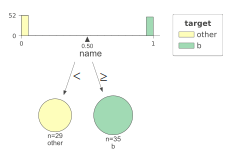

In [33]:
estimators = forest.estimators_
viz = dtreeviz(
    estimators[0],
    X_train,
    y_train,
    target_name='target',
    feature_names=columns,
    class_names=[str(i) for i in ['other', 'b']]
)

viz

ここで先ほどのRandom Forestの決定木について、その構造を表示してみる。

上記の図からわかるように、「0または1」という2択ではなく「1未満あるいは1以上」という条件分岐が設定されている。これは、トレーニングセットに`LabelEncoder()`で処理された0と1の2値を連続値として解釈しているため。そのため、`LabelEncoder()`処理後の数値は数値の大小に本来意味がないにもかかわらず、「意味を持たせてしまう」ような判斷をしている。

原因は、Random ForestにはLightGBMのように明示的にカテゴリ変数を指定するパラメータが存在しないことと、`LabelEncoder()`のデフォルト設定が「アルファベット順や数字順でラベルを設定する」ようになっているため。

今回のデータは「たまたま」トレーニングセットに存在しないデータ（「c」のこと）が、トレーニングセットのデータ（「a」と「b」のこと）よりアルファベット順で後ろだったため、ラベル変換の時点で「a, b, c」を「0, 1, 2」として変換してしまった。さらにこのデータを連続値として解釈し、それに基づく大小関係を分岐の条件としたため、予測値がLightGBMとRandom Forestで異なった結果となった。

本来`LabelEncoder()`の処理自体は決定木ベースのアルゴリズムと相性がいい（そもそも、One-Hot-Encodingと決定木の相性があまり良くない。特に特徴量が多ければ多いほど処理コストが増大しがち）のだけど、上記のように裏目に出るケースが存在する（多少、上記は極端な例ではあるが）。

ある特徴量において、いかに「データの内容や取り得る可能性のある値を確定できるか」、そして「それに基づいてどんな前処理を行うか（さらにはどんなアルゴリズムを使うか）を判斷するか」は、非常に重要であり難しい。大抵の場合、（特にカテゴリ変数は）入力される可能性のある値が多岐に渡り、しかも入力パターンが増える傾向があるので、そのような値をどこまでハンドリングしてどのように処理するかが、精度向上の重要な要素になる。